POLITICAL BIAS

In [10]:
from google.colab import drive
import pandas as pd
from IPython.display import display
from tqdm import tqdm

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
csv_file_path = '/content/drive/MyDrive/Colab Notebooks/data/processed/random_selected_articles_summaries_gpt.csv'

In [13]:
df = pd.read_csv(csv_file_path)

In [14]:
display(df.head())

,title,cleaned_article,summary
0,Poland abortion: Polish women look for help in...,Poland abortion Polish women look for help in ...,Poland’s recent near-total abortion ban has dr...
1,Hong Kong Cardinal advocates for promoting a c...,Hong Kong Cardinal advocates for promoting a c...,"In his message for Pro-Life Day 2020, Cardinal..."
2,Sex Education in the Philippines - The Borgen ...,Sex Education in the Philippines - The Borgen ...,Sex education in the Philippines is aimed at e...
3,"When a fetal scan showed problems, she fled Id...","When a fetal scan showed problems, she fled Id...","Jillaine St. Michel, a 37-year-old Idaho resid..."
4,Prioritizing the Neglected Areas of SRHR in Ca...,Prioritizing the Neglected Areas of SRHR in Ca...,The policy brief from Action Canada for Sexual...


In [15]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="bucketresearch/politicalBiasBERT")

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
# Load model directly
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("bucketresearch/politicalBiasBERT")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [17]:
def score_article(article):
    # Tokenize the input article
    inputs = tokenizer(article, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    # Apply softmax to get probabilities
    probs = torch.softmax(outputs.logits, dim=1)

    # Get predicted class and probability
    predicted_class = torch.argmax(probs, dim=1).item()
    class_probabilities = probs.squeeze().tolist()

    return predicted_class, class_probabilities


In [18]:
# Append results to the list
      # [0] -> left
      # [1] -> center
      # [2] -> right
# Initialize a list to store results
results = []
# Iterate over the first 10 articles in the DataFrame
for _, article in tqdm(df.iterrows()):  # Using iterrows() to access each row
    # Score the cleaned article
    article_predicted_class, article_class_probabilities = score_article(article['cleaned_article'])

    # Score the summary
    summary_predicted_class, summary_class_probabilities = score_article(article['summary'])

    # Append results to the list
    results.append({
        "Article Title": article['title'],  # Assuming you want to use the article's title
        "Article Predicted Class": article_predicted_class,
        "Article Class Probabilities": article_class_probabilities,
        "GPT Predicted Class": summary_predicted_class,
        "GPT Class Probabilities": summary_class_probabilities
    })

# Convert the results to a DataFrame
df = pd.DataFrame(results)

# Display the results in tabular format
display(df)


293it [03:48,  1.28it/s]


,Article Title,Article Predicted Class,Article Class Probabilities,GPT Predicted Class,GPT Class Probabilities
0,Poland abortion: Polish women look for help in...,0,"[0.9828202724456787, 0.01291342731565237, 0.00...",1,"[0.30944210290908813, 0.5497615933418274, 0.14..."
1,Hong Kong Cardinal advocates for promoting a c...,0,"[0.5691641569137573, 0.19896818697452545, 0.23...",2,"[0.1355259120464325, 0.03153134882450104, 0.83..."
2,Sex Education in the Philippines - The Borgen ...,0,"[0.4743712842464447, 0.3002409040927887, 0.225...",1,"[0.17799322307109833, 0.7174437046051025, 0.10..."
3,"When a fetal scan showed problems, she fled Id...",2,"[0.34862491488456726, 0.19945979118347168, 0.4...",0,"[0.41481250524520874, 0.31836485862731934, 0.2..."
4,Prioritizing the Neglected Areas of SRHR in Ca...,0,"[0.6540040373802185, 0.28962966799736023, 0.05...",0,"[0.7804050445556641, 0.18766172230243683, 0.03..."
...,...,...,...,...,...
288,Pueblo Council decision on anti-abortion ordin...,2,"[0.3037261962890625, 0.13101215660572052, 0.56...",2,"[0.1488608419895172, 0.05272804573178291, 0.79..."
289,Louisiana House guts abortion bill that could ...,2,"[0.1488608419895172, 0.05272804573178291, 0.79...",2,"[0.20670589804649353, 0.08668540418148041, 0.7..."
290,Onslaught of new abortion restrictions looms i...,0,"[0.6407642364501953, 0.22402724623680115, 0.13...",1,"[0.14221957325935364, 0.7977362871170044, 0.06..."
291,Indiana abortion clinics stop providing aborti...,1,"[0.0937495157122612, 0.8912051320075989, 0.015...",1,"[0.335097074508667, 0.4482349753379822, 0.2166..."


from matplotlib import pyplot as plt
df['Article Predicted Class'].plot(kind='hist', bins=20, title='Article Predicted Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['GPT Predicted Class'].plot(kind='hist', bins=20, title='GPT Predicted Class')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='Article Predicted Class', y='GPT Predicted Class', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df['Article Predicted Class'].plot(kind='line', figsize=(8, 4), title='Article Predicted Class')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df['GPT Predicted Class'].plot(kind='line', figsize=(8, 4), title='GPT Predicted Class')
plt.gca().spines[['top', 'right']].set_visible(False)

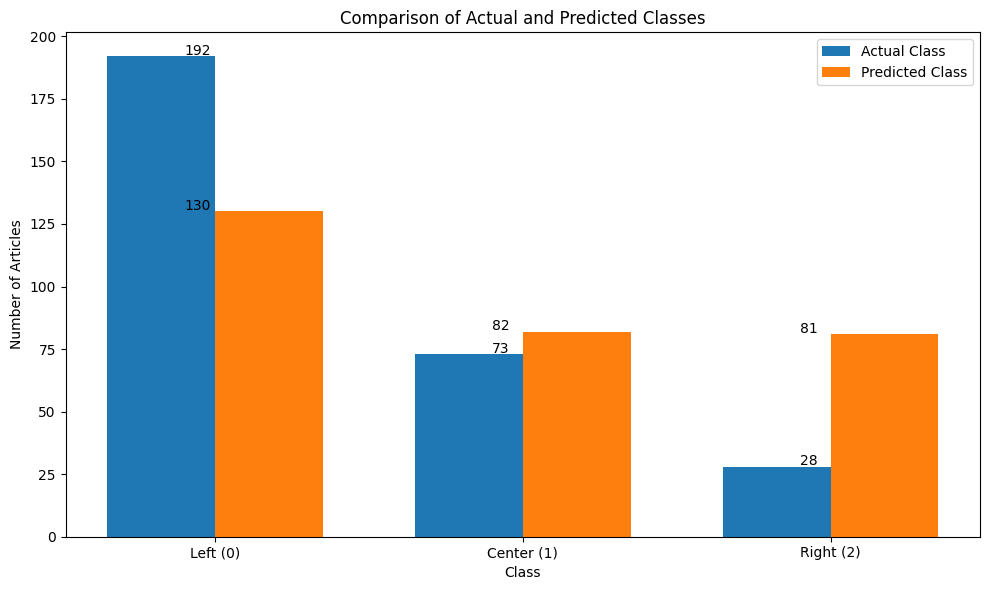

In [31]:
# prompt: Using dataframe df: generate bar chart with comparison between actual and predicted classes using separate bars use labels for 0 as left, 1 as center and 2 as right

import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Group data by actual and predicted classes
actual_counts = df.groupby('Article Predicted Class').size().reset_index(name='Actual Count')
predicted_counts = df.groupby('GPT Predicted Class').size().reset_index(name='Predicted Count')


# Create a bar chart
width = 0.35  # width of bars

fig, ax = plt.subplots(figsize=(10, 6))
actual_bars = ax.bar(actual_counts['Article Predicted Class'] - width/2, actual_counts['Actual Count'], width, label='Actual Class')
predicted_bars = ax.bar(predicted_counts['GPT Predicted Class'] + width/2, predicted_counts['Predicted Count'], width, label='Predicted Class')

# Customize the plot
ax.set_xlabel('Class')
ax.set_ylabel('Number of Articles')
ax.set_title('Comparison of Actual and Predicted Classes')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Left (0)', 'Center (1)', 'Right (2)'])  # Set custom labels
ax.legend()

# Add labels to the top of each bar
def addlabels(x,y,z):
    for i in range(len(x)):
        plt.text(i-0.1,y[i]+0.5,z[i])


addlabels(actual_counts['Article Predicted Class'], actual_counts['Actual Count'], actual_counts['Actual Count'].astype(int))
addlabels(predicted_counts['GPT Predicted Class'], predicted_counts['Predicted Count'], predicted_counts['Predicted Count'].astype(int))
plt.tight_layout()
plt.show()

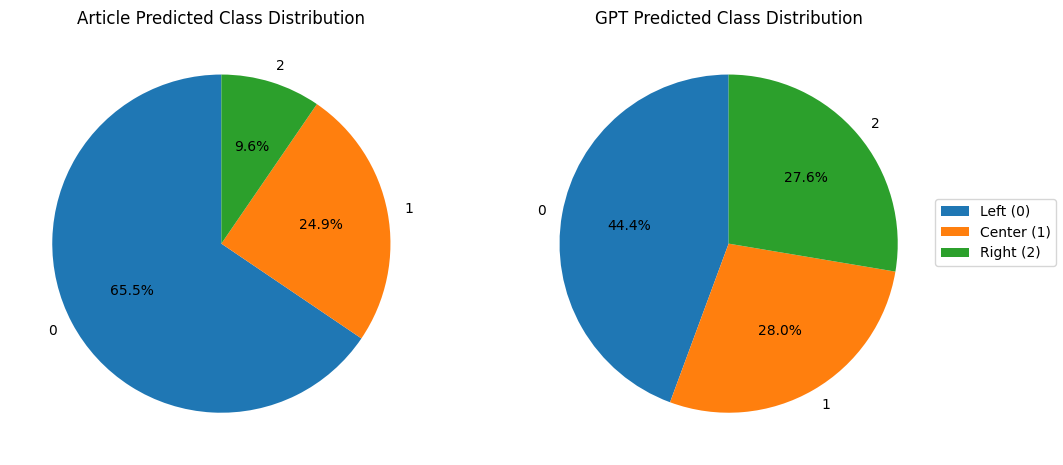

In [24]:
# prompt: Using dataframe df: combined pi chart for both and add a legend which says 0 is left, 1 is center and 2 is right

import pandas as pd
import matplotlib.pyplot as plt

# Calculate the value counts for each predicted class
article_class_counts = df['Article Predicted Class'].value_counts()
gpt_class_counts = df['GPT Predicted Class'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Article Predicted Class Pie Chart
axes[0].pie(article_class_counts, labels=article_class_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Article Predicted Class Distribution')

# GPT Predicted Class Pie Chart
axes[1].pie(gpt_class_counts, labels=gpt_class_counts.index, autopct='%1.1f%%', startangle=90)
axes[1].set_title('GPT Predicted Class Distribution')

# Add a common legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Left (0)', 'Center (1)', 'Right (2)'], loc='center right')


plt.show()


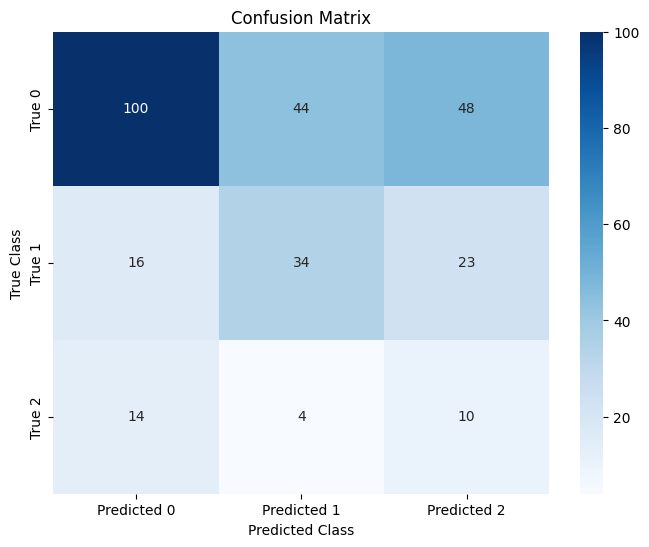

In [21]:
# prompt: Using dataframe df: confusion matrix

import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Article Predicted Class' is the true label and 'GPT Predicted Class' is the prediction
y_true = df['Article Predicted Class']
y_pred = df['GPT Predicted Class']


cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1', 'Predicted 2'],
            yticklabels=['True 0', 'True 1', 'True 2'])
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()


Hallucination

In [ ]:
# # Use a pipeline as a high-level helper
# from transformers import pipeline

# pipe = pipeline("text-classification", model="vectara/hallucination_evaluation_model", trust_remote_code=True)

In [ ]:
# from transformers import AutoModelForSequenceClassification, PreTrainedTokenizerFast
# import torch
# # Load model directly
# from transformers import AutoModelForSequenceClassification
# model = AutoModelForSequenceClassification.from_pretrained("vectara/hallucination_evaluation_model", trust_remote_code=True)

In [ ]:
# import pandas as pd
# from transformers import AutoModelForSequenceClassification


# # Article text
# article_text = """
# Following a recent constitutional court ruling that imposes a near-total ban on abortion in Poland, widespread protests erupted, marking the largest demonstrations since the fall of communism in 1989. The protests, primarily organized by the grassroots initiative Women’s Strike, are characterized by several significant symbols. The red lightning bolt, designed by Ola Jasionowska, serves as a warning against depriving women of their rights, although critics have attempted to associate it with Nazi insignia. The slogan "Wypierdala," meaning "Fuck off," has been prominently used, often alongside the iconic Solidarity logo. Other notable symbols include coat hangers, which highlight the dangers of illegal abortions, black umbrellas symbolizing mourning and resistance, and the anchor symbol representing Poland's fight against occupation, which has been adapted to signify "Polish Women Fighting." These symbols reflect the deep-seated anger towards the ruling Law and Justice party and the Catholic Church's influence over reproductive rights in Poland, showcasing the protestors' determination to defend women's rights.
# """

# # Summary text
# summary_text = """
# Following a recent constitutional court ruling that imposes a near-total ban on abortion in Poland, widespread protests erupted, marking the largest demonstrations since the fall of communism in 1989. The protests, primarily organized by the grassroots initiative Women’s Strike, are characterized by several significant symbols, such as the red lightning bolt, the slogan "Wypierdala," coat hangers, black umbrellas, and an adapted anchor symbol. These symbols reflect the protestors' anger towards the ruling Law and Justice party and the Catholic Church's influence over reproductive rights, showcasing their determination to defend women's rights.
# """


# # Define the test data, List[Tuple[str, str]]
# pairs = [
#     (article_text, summary_text)
# ]

# # Step 1: Load the model
# model = AutoModelForSequenceClassification.from_pretrained('vectara/hallucination_evaluation_model', trust_remote_code=True)

# # Step 2: Use the model to predict
# # Here you may need to transform pairs to the required input format if necessary
# predictions = model.predict(pairs).numpy()  # Assuming predictions return an array-like structure

# # Prepare the predictions (0 means not hallucinated, 1 means hallucinated)
# # You might need to apply a threshold based on your model's outputs
# # For demonstration, let's assume values close to 0.5 are considered hallucinated (use your model's logic)
# predicted_labels = [1 if pred > 0.5 else 0 for pred in predictions]

# # Create a DataFrame to display results in tabular format
# results_df = pd.DataFrame({
#    'Prediction': predicted_labels
# })

# # Display the results
# print(results_df)
